## 1.Camera Calibration

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

chessboard_size = (9,6)

def calibrate_camera(directory,image_files,chessboard_size):
    chessboard_point_num = chessboard_size[0]*chessboard_size[1]
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image place

    # Prepare object points
    objp = np.zeros((chessboard_point_num,3),np.float32)
    objp[:,:2] = np.mgrid[0:chessboard_size[0],0:chessboard_size[1]].T.reshape(-1,2)

    for image_file in image_files:
        image = cv2.imread(directory+image_file)
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        
        # Find chessboard corners
        ret, corners = cv2.findChessboardCorners(gray,chessboard_size,None)
        
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    if(len(objpoints) == 0 or len(imgpoints) == 0):
        raise Error("Calibration Failed")
    print(gray.shape)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape,None,None)    
    return mtx, dist


In [3]:
import os

calbration_directory = 'camera_cal/'
image_files = os.listdir(calbration_directory)
mtx,dist = calibrate_camera(calbration_directory,image_files,chessboard_size)

(720, 1280)


## 2. Distortion Correction

In [4]:
def undistort(image,mtx,dist):
    image = cv2.undistort(image,mtx,dist,mtx)
    return image

In [5]:
chessboard_dist = cv2.imread('camera_cal/calibration2.jpg')
chessboard_undist = undistort(chessboard_dist,mtx,dist)
#f,((ax1,ax2)) = plt.subplots(1,2,figsize=(12,18))
#ax1.imshow(chessboard_dist)
#ax1.set_title('origin')
#ax2.imshow(chessboard_undist)
#ax2.set_title('undist')

## 3. Color Transform

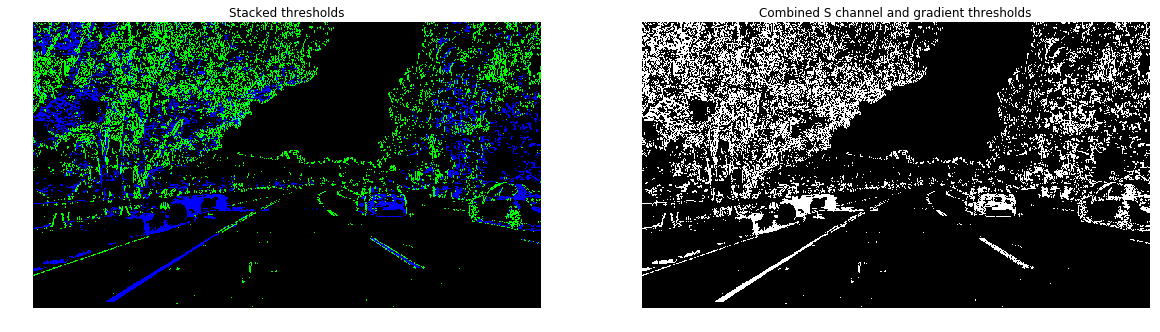

In [7]:
def threshold_binary(undist_image):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(undist_image, cv2.COLOR_RGB2HLS).astype("float")
    s_channel = hls[:,:,2]
    
    # Sobel x
    gray = cv2.cvtColor(undist_image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return color_binary, combined_binary

img = cv2.imread("test_images/test5.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

undistorted_img = undistort(img, mtx, dist)
color_binary, combined_binary = threshold_binary(undistorted_img)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title("Stacked thresholds")
ax1.imshow(color_binary)
ax1.axis("off");

# save as file
binary = 255 * color_binary.astype("uint8")
binary = cv2.cvtColor(binary, cv2.COLOR_RGB2BGR)
cv2.imwrite("output_images/color_binary.jpg", binary)

ax2.set_title("Combined S channel and gradient thresholds")
ax2.imshow(combined_binary, cmap="gray")
ax2.axis("off");

# save as file
binary = 255 * combined_binary.astype("uint8")
cv2.imwrite("output_images/combined_binary.jpg", binary);

## 4. Perspective Transform

(-0.5, 1279.5, 719.5, -0.5)

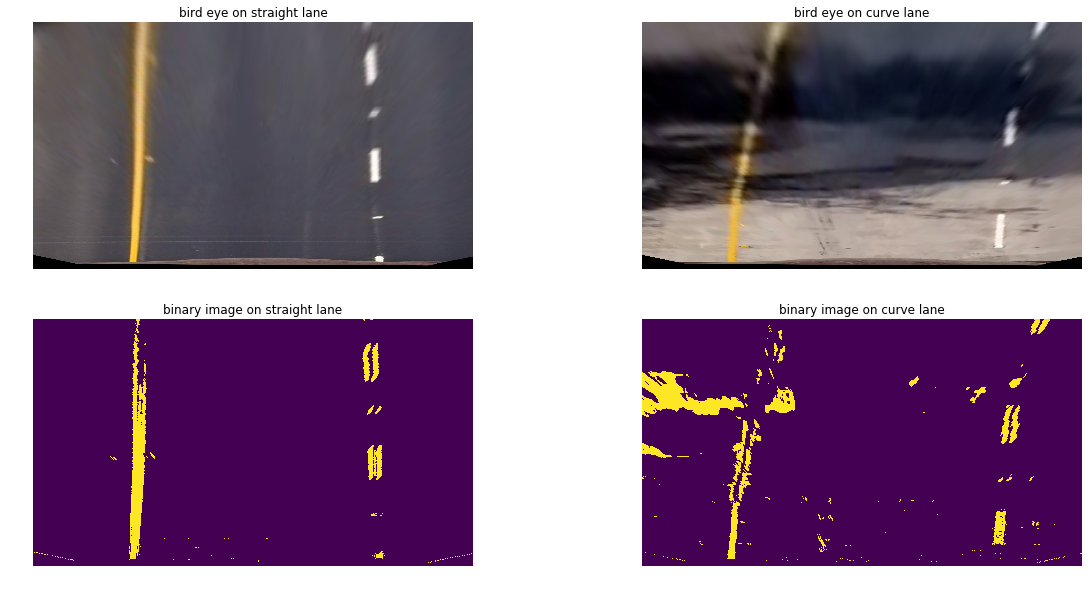

In [51]:
src_points = np.float32(
    [[253,697],
     [1061,690],
     [700,456],
     [585,456]])

dst_points = np.float32(
    [[303,697],
     [1011,697],
     [1011,0],
     [303,0]])
M = cv2.getPerspectiveTransform(src_points,dst_points)
Minv = cv2.getPerspectiveTransform(dst_points,src_points)
#cv2.warpPerspective(src,M,size,flags=cv2.INTER_LINEAR)


image_straight = cv2.imread("test_images/straight_lines1.jpg")
image_curve = cv2.imread("test_images/test5.jpg")

image_straight = cv2.cvtColor(image_straight,cv2.COLOR_BGR2RGB)
image_curve = cv2.cvtColor(image_curve,cv2.COLOR_BGR2RGB)

image_straight = undistort(image_straight, mtx, dist)
image_curve = undistort(image_curve,mtx,dist)

image_straight = cv2.warpPerspective(image_straight,M,(image_straight.shape[1],image_straight.shape[0]),flags=cv2.INTER_LINEAR)
image_curve = cv2.warpPerspective(image_curve,M,(image_curve.shape[1],image_curve.shape[0]),flags=cv2.INTER_LINEAR)

_,image_straight_binary = threshold_binary(image_straight)
_,image_curve_binary = threshold_binary(image_curve)

# test image
# Plotting thresholded images
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
ax1.set_title("bird eye on straight lane")
ax1.imshow(image_straight)
ax1.axis("off");

ax2.set_title("bird eye on curve lane")
ax2.imshow(image_curve, cmap="gray")
ax2.axis("off");

ax3.set_title("binary image on straight lane")
ax3.imshow(image_straight_binary)
ax3.axis("off")

ax4.set_title("binary image on curve lane")
ax4.imshow(image_curve_binary)
ax4.axis("off")

## 5.Finding Lines

In [66]:
def get_curvature(left_fit, right_fit,left_fitx,left_fity,ploty,image_size):
    y_eval = np.max(ploty)
    
    # Convert from pixels to metres.
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    #left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Now our radius of curvature is in meters
    # Example values: 632.1 m    626.2 m
    
    # Calculate Lane Deviation from center of lane:
    # First we calculate the intercept points at the bottom of our image, then use those to 
    # calculate the lane deviation of the vehicle (assuming camera is in center of vehicle)
    scene_height = image_size[0] * ym_per_pix
    scene_width = image_size[1] * xm_per_pix
    
    left_intercept = left_fit[0] * scene_height ** 2 + left_fit[1] * scene_height + left_fit[2]
    right_intercept = right_fit[0] * scene_height ** 2 + right_fit[1] * scene_height + right_fit[2]
    calculated_center = (left_intercept + right_intercept) / 2.0
    
    lane_deviation = (calculated_center - scene_width / 2.0)
    
    return left_curverad, right_curverad, lane_deviation


def find_lines(binary_warped,nwindows = 9):
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:],axis = 0)
    out_img = np.dstack((binary_warped,binary_warped,binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
     
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    left_curverad, right_curverad, lane_deviation = get_curvature(left_fit,right_fit,left_fitx,right_fitx,ploty,binary_warped.shape)
    
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    return left_fitx,right_fitx,ploty,left_curverad,right_curverad,lane_deviation

img = cv2.imread("test_images/test6.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

undistorted_img = undistort(img, mtx, dist)
color_binary, combined_binary = threshold_binary(undistorted_img)
warped_binary = cv2.warpPerspective(combined_binary,M,(combined_binary.shape[1],combined_binary.shape[0]),flags=cv2.INTER_LINEAR)
#plt.imshow(warped_binary)
#find_lines(warped_binary)

## 6. Image Process PipeLine

C:\Users\hds\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


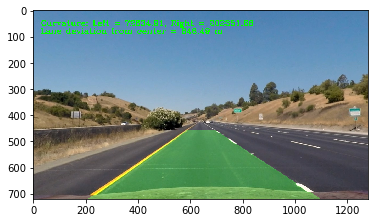

In [77]:
def draw_lanes_on_image(binary_warped, undistorted_img, Minv, left_fitx, right_fitx, ploty, left_radius, right_radius, lane_deviation):
    """
    Draw the found lane lines onto a binary warped image, then unwarp
    and overlay on the original image.
    
    binary_warped
    Minv
    left_fitx
    right_fitx
    ploty
    """
    
    # Create a blank image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    curvature_text = "Curvature: Left = " + str(np.round(left_radius, 2)) + ", Right = " + str(np.round(right_radius, 2)) 
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, curvature_text, (30, 60), font, 1, (0,255,0), 2)
    deviation_text = "Lane deviation from center = {:.2f} m".format(lane_deviation) 
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, deviation_text, (30, 90), font, 1, (0,255,0), 2)
        
    return result

def process_image(image,mtx,dist,M,Minv):
    undistorted_img = undistort(image,mtx,dist)
    _, combined_binary = threshold_binary(undistorted_img)
    binary_warped = cv2.warpPerspective(combined_binary,M,(combined_binary.shape[1],combined_binary.shape[0]),flags=cv2.INTER_LINEAR)   
    
    left_fitx,right_fitx,ploty,left_rad,right_rad,lane_deviation = find_lines(binary_warped)    
    out_img = draw_lanes_on_image(binary_warped,undistorted_img,Minv,left_fitx,right_fitx,ploty,left_rad,right_rad,lane_deviation)
    return out_img

img = cv2.imread("test_images/straight_lines1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

out_img = process_image(img,mtx,dist,M,Minv)

plt.imshow(out_img)